# imports

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import os
from os import listdir
from os.path import isfile, join
from tqdm import tqdm
import cv2
import pickle
import datetime
import time
import random
import collections

import tensorflow as tf
from tensorflow.keras import optimizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator 
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.callbacks import TensorBoard, LearningRateScheduler, ModelCheckpoint, CSVLogger, EarlyStopping
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import BatchNormalization
import multiprocessing as mp
from sklearn.model_selection import train_test_split

In [28]:
def prepare_test_data():
    data_set = []
    test_dir = '/Users/flo/Desktop/456/_SEMESTER_PROJECT/food-101/test_group' 
    features = []
    labels = []
    file_names = []
    # pre-process: re-size and re-color
    for noodle_class in noodle_classes:
        path = os.path.join(test_dir, noodle_class)
        label = noodle_classes.index(noodle_class) # FIX LATER: use enumerate
        print(noodle_class,label)
        #input('wait1')

        for img in os.listdir(path): # pad_thai/1432432.jpg, pad_thai/12314.jpg . . .
                if img.startswith('.'): # .DS_Storeimport numpy as np
                    continue
                # each image is a 2D array of RGB value
                try:
                    img_arr = cv2.imread(os.path.join(path,img))
                    #img_to_rgb = img_arr[:,:,::-1] 
                    new_img = cv2.resize(img_arr,(227,227)) 
                    file_names.append(img)
                    features.append(new_img) # shove (X,y) in here cause we wanna shuffle 
                    labels.append(label)
                except Exception as e:
                    print("create exception: ",e)
        
    X = np.array(features).reshape(-1, 227, 227, 3) # -1 = any number of features (catch-all, it'll recognize)
    y = np.array(labels).reshape(-1, 1)

    return X,y,file_names

# load and pre-process data by subtracting mean per channel from each image

In [4]:

NUM_CLASSES = 5
noodle_classes = ['pad_thai','pho','ramen','spaghetti_bolognese','spaghetti_carbonara']

#root_dir = 'food-101/images/'

# this function pre-processes every food image
# and assigns label to the respective food class
# shoves everything into an array called data_set
# shuffles the array
# then separates the data_set array into features array and label array
def create_data(root, _name):
    data_set = []
    features = []
    labels = []
    # pre-process: re-size and re-color
    for noodle_class in noodle_classes:
        path = os.path.join(root, noodle_class)
        label = noodle_classes.index(noodle_class) # FIX LATER: use enumerate
        #print(noodle_class,label)
        #input('wait1')
        for img in os.listdir(path): # pad_thai/1432432.jpg, pad_thai/12314.jpg . . .
            if img.startswith('.'): # .DS_Store
                continue
            # each image is a 2D array of RGB value
            try:
                img_arr = cv2.imread(os.path.join(path,img))
                new_img = cv2.resize(img_arr, (227, 227))
                new_img = new_img.astype('float32')
                per_channel_mean = np.mean(new_img, axis=(0))
                new_img = np.subtract(per_channel_mean,new_img) #i want this cause cv2 inverted
                
                #plt.imshow(resized_img)
                #plt.show()

                features.append(new_img)
                labels.append(label) # shove (X,y) in here cause we wanna shuffle 
                #print(data_set)
            except Exception as e:
                print("create exception: ",e,"on",img)

        

    X = np.array(features).reshape(-1, 227, 227, 3)
    y = np.array(labels).reshape(-1, 1)
    X = X.astype('float32')
    #save(X,y,_name)
    
    return X,y


In [5]:
X_train, y_train = create_data('food-101/train', "train")
X_valid, y_valid = create_data('food-101/valid',"valid")

X_train = tf.keras.utils.normalize(X_train, axis=1)
y_train = tf.keras.utils.to_categorical(y_train, NUM_CLASSES)

X_valid = tf.keras.utils.normalize(X_valid, axis=1)
y_valid = tf.keras.utils.to_categorical(y_valid, NUM_CLASSES)

X_test, y_test = prepare_test_data()
X_test = tf.keras.utils.normalize(X_test, axis=1)
y_test = tf.keras.utils.to_categorical(y_test, NUM_CLASSES)

test_datagen = ImageDataGenerator()
test_datagen.fit(X_test)
test_generator = test_datagen.flow(X_test, y_test, batch_size=32, shuffle=False)

pad_thai 0
pho 1
ramen 2
spaghetti_bolognese 3
spaghetti_carbonara 4


# iteration 30

In [6]:
print("X after normal",X_train[0][0][0])
print("y after normal",y_train[0])

print("X_train shape", X_train.shape)
print("X_valid shape", X_valid.shape)
print("y_train shape", y_train.shape)
print("y_valid shape", y_valid.shape)


_iter = 34
learn_rate = 0.001
epochs = 30
batch_size=32

NAME = "{}-{}-bsz-{}-lr-{}-ep".format(_iter,
                                        batch_size,
                                        learn_rate,
                                        epochs,
                                        int(time.time()))

#log_dir="logs/" + NAME + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
#logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
#tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir)

# specify model
model = Sequential()

# layer 1: Conv1 + Relu + MaxPool
model.add(Conv2D(96, (11,11), strides=4, padding='valid',input_shape = X_train.shape[1:]))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2),strides=2))

# layer 2: Conv2 + Relu + MaxPool
model.add(Conv2D(256, (3,3), strides=1, padding='valid'))
#model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2),strides=2))

# #layer 3: Conv3 + Relu
# model.add(Conv2D(384, (5,5), strides=1, padding='valid'))
# model.add(Activation('relu'))

# # layer 4: Conv4 + Relu
# model.add(Conv2D(384, (3,3), strides=1, padding='valid'))
# model.add(Activation('relu'))

# # layer 5: Conv5 + Relu + MaxPool + Dropout
model.add(Conv2D(256, (3,3), strides=1))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2), strides=2))
model.add(Dropout(0.3))

# # flatten before dense/fcc
model.add(Flatten())

# # layer 6: FC6 + Relu + Dropout
model.add(Dense(4096))
model.add(Activation('relu'))
#model.add(Dropout(0.50)) #bad to add drop out right before the last layer?

# layer 7: FC7 + Relu
model.add(Dense(4096))
model.add(Activation('relu'))

# layer 8: FC8 + Relu
model.add(Dense(NUM_CLASSES))
model.add(Activation('softmax'))


# optimizer: adjust learning rates
# adam pros: low memory, works well for deep nets
#adam = tf.keras.optimizers.Adam(lr=learn_rate)
opt = optimizers.SGD(lr=learn_rate, momentum=.9)

model.compile(loss="categorical_crossentropy",
              optimizer=opt,
              metrics=['accuracy'])

checkpoint_path = "/Users/flo/Desktop/456/_SEMESTER_PROJECT/checkpoints/"+NAME
checkpointer = ModelCheckpoint(filepath=checkpoint_path+'.{epoch:02d}-{val_loss:.2f}.hdf5', verbose=1, save_best_only=True)

def schedule(epoch):
    if epoch < 15:
        return .001
    elif epoch < 25:
        return .0005
    else:
        return .00001
lr_scheduler = LearningRateScheduler(schedule)

train_datagen = ImageDataGenerator(
    featurewise_center=False,
    featurewise_std_normalization=False,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True)
train_datagen.fit(X_train)

valid_datagen = ImageDataGenerator(
    featurewise_center=False,
    featurewise_std_normalization=False,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True)
valid_datagen.fit(X_valid)

train_generator = train_datagen.flow(X_train, y_train, batch_size=batch_size,shuffle=True)
valid_generator = valid_datagen.flow(X_valid, y_valid, batch_size=batch_size,shuffle=True)

print("Training start ",datetime.datetime.now().strftime("%H:%M:%S"))
hist = model.fit_generator(train_generator,
                           validation_data=valid_generator,
                           epochs=epochs,      # epochs = how many times go through the network
                           steps_per_epoch=X_train.shape[0]//batch_size, # number of batch iterations before an epoch is finished
                           validation_steps=X_valid.shape[0]//batch_size,
                           shuffle=True,
                           callbacks=[checkpointer,lr_scheduler])
print("Training end ",datetime.datetime.now().strftime("%H:%M:%S"))

X after normal [-0.02995581 -0.01778729 -0.01882338]
y after normal [1. 0. 0. 0. 0.]
X_train shape (3750, 227, 227, 3)
X_valid shape (875, 227, 227, 3)
y_train shape (3750, 5)
y_valid shape (875, 5)
Training start  10:43:50
Epoch 1/30
116/117 [============================>.] - ETA: 1s - loss: 1.5650 - accuracy: 0.2727
Epoch 00001: val_loss improved from inf to 1.59242, saving model to /Users/flo/Desktop/456/_SEMESTER_PROJECT/checkpoints/30-32-bsz-0.001-lr-30-ep.01-1.59.hdf5
117/117 [==============================] - 138s 1s/step - loss: 1.5642 - accuracy: 0.2735 - val_loss: 1.5924 - val_accuracy: 0.3391
Epoch 2/30
116/117 [============================>.] - ETA: 0s - loss: 1.4484 - accuracy: 0.3719
Epoch 00002: val_loss improved from 1.59242 to 1.55162, saving model to /Users/flo/Desktop/456/_SEMESTER_PROJECT/checkpoints/30-32-bsz-0.001-lr-30-ep.02-1.55.hdf5
117/117 [==============================] - 127s 1s/step - loss: 1.4481 - accuracy: 0.3728 - val_loss: 1.5516 - val_accuracy: 0.346

Epoch 24/30
116/117 [============================>.] - ETA: 1s - loss: 0.8127 - accuracy: 0.6894
Epoch 00024: val_loss did not improve from 0.78996
117/117 [==============================] - 135s 1s/step - loss: 0.8126 - accuracy: 0.6899 - val_loss: 0.7915 - val_accuracy: 0.7083
Epoch 25/30
116/117 [============================>.] - ETA: 1s - loss: 0.8162 - accuracy: 0.6923
Epoch 00025: val_loss did not improve from 0.78996
117/117 [==============================] - 143s 1s/step - loss: 0.8162 - accuracy: 0.6918 - val_loss: 0.8019 - val_accuracy: 0.6852
Epoch 26/30
116/117 [============================>.] - ETA: 1s - loss: 0.8147 - accuracy: 0.6839
Epoch 00026: val_loss improved from 0.78996 to 0.74678, saving model to /Users/flo/Desktop/456/_SEMESTER_PROJECT/checkpoints/30-32-bsz-0.001-lr-30-ep.26-0.75.hdf5
117/117 [==============================] - 140s 1s/step - loss: 0.8149 - accuracy: 0.6840 - val_loss: 0.7468 - val_accuracy: 0.7106
Epoch 27/30
116/117 [===========================

In [7]:
model.save_weights('/Users/flo/Desktop/456/_SEMESTER_PROJECT/saved_models/34.h5')
model.summary()

scores = model.evaluate(X_valid, y_valid, verbose=2)
print('Valid loss:', scores[0])
print('Valid accuracy:', scores[1])

test_scores = model.predict_generator(test_generator, verbose=2)
print('Test loss:', test_scores[0])
print('test accuracy:', test_scores[1])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 55, 55, 96)        34944     
_________________________________________________________________
batch_normalization (BatchNo (None, 55, 55, 96)        384       
_________________________________________________________________
activation (Activation)      (None, 55, 55, 96)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 27, 27, 96)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 25, 25, 256)       221440    
_________________________________________________________________
activation_1 (Activation)    (None, 25, 25, 256)       0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 12, 12, 256)       0

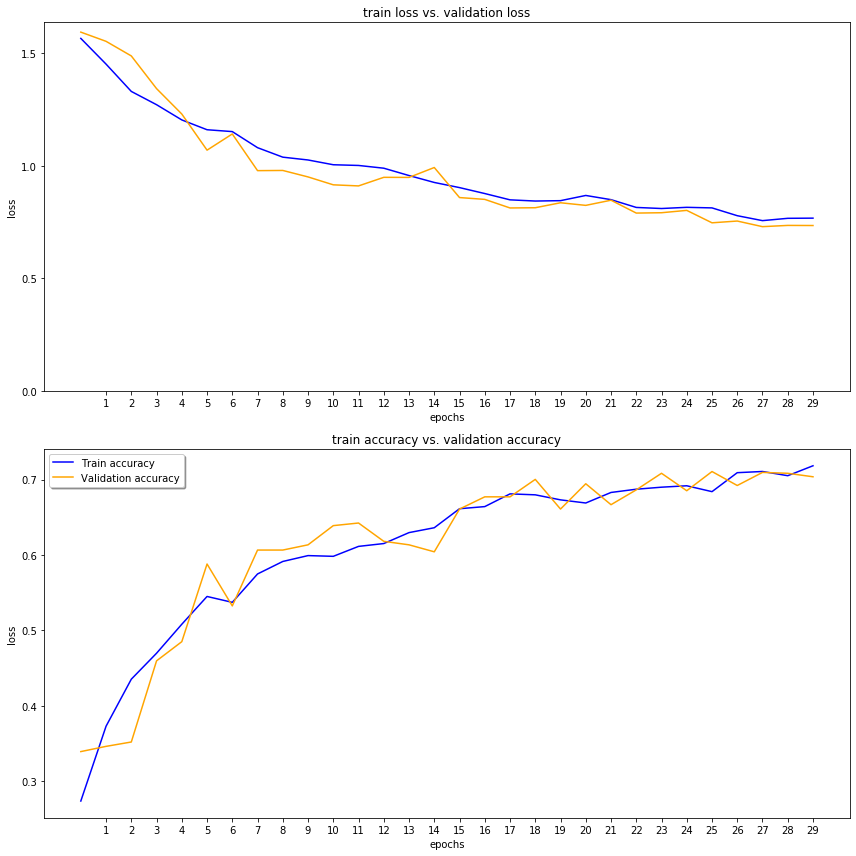

In [8]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))
ax1.plot(hist.history['loss'], color='b', label="Train loss")
ax1.plot(hist.history['val_loss'], color='#ffa500', label="Validation loss")
ax1.set_xticks(np.arange(1, epochs, 1))
ax1.set_yticks(np.arange(0, 2, 0.5))
ax1.set_ylabel('loss')
ax1.set_title('train loss vs. validation loss')
ax1.set_xlabel('epochs')

ax2.plot(hist.history['accuracy'], color='b', label="Train accuracy")
ax2.plot(hist.history['val_accuracy'], color='#ffa500',label="Validation accuracy")
ax2.set_xticks(np.arange(1, epochs, 1))
ax2.set_ylabel('loss')
ax2.set_title('train accuracy vs. validation accuracy')
ax2.set_xlabel('epochs')

legend = plt.legend(loc='best', shadow=True)
plt.tight_layout()
plt.show()

# iteration 31
# epoch 40 
# more lr at the end

In [9]:
print("X after normal",X_train[0][0][0])
print("y after normal",y_train[0])

print("X_train shape", X_train.shape)
print("X_valid shape", X_valid.shape)
print("y_train shape", y_train.shape)
print("y_valid shape", y_valid.shape)


_iter = 35
learn_rate = 0.001
epochs = 40
batch_size=32

NAME = "{}-{}-bsz-{}-lr-{}-ep".format(_iter,
                                        batch_size,
                                        learn_rate,
                                        epochs,
                                        int(time.time()))

#log_dir="logs/" + NAME + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
#logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
#tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir)

# specify model
model = Sequential()

# layer 1: Conv1 + Relu + MaxPool
model.add(Conv2D(96, (11,11), strides=4, padding='valid',input_shape = X_train.shape[1:]))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2),strides=2))

# layer 2: Conv2 + Relu + MaxPool
model.add(Conv2D(256, (3,3), strides=1, padding='valid'))
#model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2),strides=2))

# #layer 3: Conv3 + Relu
# model.add(Conv2D(384, (5,5), strides=1, padding='valid'))
# model.add(Activation('relu'))

# # layer 4: Conv4 + Relu
# model.add(Conv2D(384, (3,3), strides=1, padding='valid'))
# model.add(Activation('relu'))

# # layer 5: Conv5 + Relu + MaxPool + Dropout
model.add(Conv2D(256, (3,3), strides=1))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2), strides=2))
model.add(Dropout(0.3))

# # flatten before dense/fcc
model.add(Flatten())

# # layer 6: FC6 + Relu + Dropout
model.add(Dense(4096))
model.add(Activation('relu'))
#model.add(Dropout(0.50)) #bad to add drop out right before the last layer?

# layer 7: FC7 + Relu
model.add(Dense(4096))
model.add(Activation('relu'))

# layer 8: FC8 + Relu
model.add(Dense(NUM_CLASSES))
model.add(Activation('softmax'))


# optimizer: adjust learning rates
# adam pros: low memory, works well for deep nets
#adam = tf.keras.optimizers.Adam(lr=learn_rate)
opt = optimizers.SGD(lr=learn_rate, momentum=.9)

model.compile(loss="categorical_crossentropy",
              optimizer=opt,
              metrics=['accuracy'])

checkpoint_path = "/Users/flo/Desktop/456/_SEMESTER_PROJECT/checkpoints/"+NAME
checkpointer = ModelCheckpoint(filepath=checkpoint_path+'.{epoch:02d}-{val_loss:.2f}.hdf5', verbose=1, save_best_only=True)

def schedule(epoch):
    if epoch < 15:
        return .001
    elif epoch < 25:
        return .0005
    else:
        return .00025
lr_scheduler = LearningRateScheduler(schedule)

train_datagen = ImageDataGenerator(
    featurewise_center=False,
    featurewise_std_normalization=False,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True)
train_datagen.fit(X_train)

valid_datagen = ImageDataGenerator(
    featurewise_center=False,
    featurewise_std_normalization=False,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True)
valid_datagen.fit(X_valid)

train_generator = train_datagen.flow(X_train, y_train, batch_size=batch_size,shuffle=True)
valid_generator = valid_datagen.flow(X_valid, y_valid, batch_size=batch_size,shuffle=True)

print("Training start ",datetime.datetime.now().strftime("%H:%M:%S"))
hist = model.fit_generator(train_generator,
                           validation_data=valid_generator,
                           epochs=epochs,      # epochs = how many times go through the network
                           steps_per_epoch=X_train.shape[0]//batch_size, # number of batch iterations before an epoch is finished
                           validation_steps=X_valid.shape[0]//batch_size,
                           shuffle=True,
                           callbacks=[checkpointer,lr_scheduler])
print("Training end ",datetime.datetime.now().strftime("%H:%M:%S"))

X after normal [-0.02995581 -0.01778729 -0.01882338]
y after normal [1. 0. 0. 0. 0.]
X_train shape (3750, 227, 227, 3)
X_valid shape (875, 227, 227, 3)
y_train shape (3750, 5)
y_valid shape (875, 5)
Training start  12:01:35
Epoch 1/40
116/117 [============================>.] - ETA: 1s - loss: 1.5489 - accuracy: 0.2930
Epoch 00001: val_loss improved from inf to 1.59028, saving model to /Users/flo/Desktop/456/_SEMESTER_PROJECT/checkpoints/35-32-bsz-0.001-lr-40-ep.01-1.59.hdf5
117/117 [==============================] - 141s 1s/step - loss: 1.5475 - accuracy: 0.2948 - val_loss: 1.5903 - val_accuracy: 0.3808
Epoch 2/40
116/117 [============================>.] - ETA: 0s - loss: 1.4415 - accuracy: 0.3625
Epoch 00002: val_loss improved from 1.59028 to 1.54509, saving model to /Users/flo/Desktop/456/_SEMESTER_PROJECT/checkpoints/35-32-bsz-0.001-lr-40-ep.02-1.55.hdf5
117/117 [==============================] - 132s 1s/step - loss: 1.4409 - accuracy: 0.3626 - val_loss: 1.5451 - val_accuracy: 0.344

Epoch 24/40
116/117 [============================>.] - ETA: 1s - loss: 0.8024 - accuracy: 0.6888
Epoch 00024: val_loss did not improve from 0.77464
117/117 [==============================] - 140s 1s/step - loss: 0.8013 - accuracy: 0.6894 - val_loss: 0.9143 - val_accuracy: 0.6250
Epoch 25/40
116/117 [============================>.] - ETA: 1s - loss: 0.8081 - accuracy: 0.6913
Epoch 00025: val_loss did not improve from 0.77464
117/117 [==============================] - 137s 1s/step - loss: 0.8078 - accuracy: 0.6912 - val_loss: 0.8334 - val_accuracy: 0.6713
Epoch 26/40
116/117 [============================>.] - ETA: 1s - loss: 0.7900 - accuracy: 0.7013
Epoch 00026: val_loss improved from 0.77464 to 0.75168, saving model to /Users/flo/Desktop/456/_SEMESTER_PROJECT/checkpoints/35-32-bsz-0.001-lr-40-ep.26-0.75.hdf5
117/117 [==============================] - 138s 1s/step - loss: 0.7917 - accuracy: 0.7006 - val_loss: 0.7517 - val_accuracy: 0.7106
Epoch 27/40
116/117 [===========================

In [16]:
X_test, y_test, filenames = prepare_test_data()
X_test = tf.keras.utils.normalize(X_test, axis=1)
y_test = tf.keras.utils.to_categorical(y_test, NUM_CLASSES)

test_datagen = ImageDataGenerator()
test_datagen.fit(X_test)
test_generator = test_datagen.flow(X_test, y_test, batch_size=32, shuffle=False)




pad_thai 0
pho 1
ramen 2
spaghetti_bolognese 3
spaghetti_carbonara 4


In [79]:
model.save_weights('/Users/flo/Desktop/456/_SEMESTER_PROJECT/saved_models/35.h5')
model.summary()

scores = model.evaluate(X_valid, y_valid, verbose=2)
print('Valid loss:', scores[0])
print('Valid accuracy:', scores[1])


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 55, 55, 96)        34944     
_________________________________________________________________
batch_normalization_1 (Batch (None, 55, 55, 96)        384       
_________________________________________________________________
activation_6 (Activation)    (None, 55, 55, 96)        0         
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 27, 27, 96)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 25, 25, 256)       221440    
_________________________________________________________________
activation_7 (Activation)    (None, 25, 25, 256)       0         
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 12, 12, 256)      

In [93]:

tdatagen = ImageDataGenerator()

tdatagener = valid_datagen.flow(X_test, y_test, batch_size = 32, shuffle=False)
tdatagen.fit(X_test)

scores = model.evaluate_generator(tdatagener, verbose=1)
print(scores)

1/1 [==============================] - 1s 691ms/step - loss: 2.0592 - accuracy: 0.1200
[2.059168577194214, 0.12]


In [83]:
scores = model.predict_classes(X_valid, verbose=2)

print(scores)

num_classes = len(scores)
score = 0
for i in range(num_classes):
    actual = noodle_classes[np.argmax(y_valid[i],axis=0)]
    #print(actual)
    #index_of_predicted_class = np.argmax(scores[i],axis=0)
    index_of_predicted_class = scores[i]
    #print(index_of_predicted_class)
    pred = noodle_classes[index_of_predicted_class]
    #acc = np.round(scores[i][index_of_predicted_class],2)
    print("\npred:",pred)
    if( pred == actual ):
        print("+1")
        score += 1
    else:
         print("actual:",actual)   
    
print(score,"out of",num_classes)


875/1 - 6s
[0 0 0 0 0 4 3 1 0 0 0 0 0 0 4 0 3 0 0 0 0 3 0 3 0 0 0 0 0 0 4 0 0 3 0 0 0
 0 0 0 0 3 0 0 0 1 3 0 0 0 0 0 0 0 0 0 4 0 0 0 0 3 0 0 0 0 0 0 0 3 4 0 0 0
 0 0 4 0 0 0 0 0 0 0 0 0 3 0 0 0 0 4 3 0 4 0 1 4 4 0 0 0 0 0 0 0 3 3 0 0 3
 0 4 0 0 1 0 3 0 0 0 0 3 0 0 0 0 4 0 0 0 0 0 0 0 0 0 0 0 3 0 0 0 0 0 0 3 0
 0 3 0 3 0 0 0 3 0 0 0 4 1 0 0 4 4 0 0 0 1 0 4 0 0 0 0 1 1 1 1 2 1 1 1 1 1
 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 0 1 1 1 1 1 1 2 1 4 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 1 1 1 1 1 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 0 1 1 1 1 1 1 2 1 1 1 4 0 1 1 1 1 1 0 1 1 1 1 2 1 1 1 1 1 1 1
 1 0 1 1 1 1 1 1 1 1 1 1 1 2 2 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 4 2 0 2 2 2 2 4 2 3 2 0 2 4 2 4 3 1 2 1 2 2
 1 0 2 2 2 4 0 2 1 2 2 2 0 0 2 0 2 2 2 2 2 2 0 2 2 2 2 4 4 2 2 2 2 1 0 2 2
 0 2 2 0 1 2 2 0 2 2 1 2 2 4 2 2 2 4 1 2 0 1 2 2 0 2 2 2 2 2 2 4 2 2 2 2 2
 2 2 1 2 1 2 0 2 2 2 2 2 1 2 2 4 4 2 2 2 2 2 3 2 0 2 2 1 0 2 1 0 2 1 2 2 1
 0 0 1 0 2 4 0

# evaluate model on test data

In [90]:
# print(test_scores)
# print(test_scores[1])
#print(y_test)
print(y_valid[5])

img = noodle_classes[index_of_predicted_class_acc]+"/"+filenames[0]
#print('File:',img)

#print(len(test_scores))
num_classes = len(scores)
score = 0
for i in range(num_classes):
    actual = noodle_classes[np.argmax(y_valid[i],axis=0)]
    #print(actual)
    #index_of_predicted_class = np.argmax(scores[i],axis=0)
    index_of_predicted_class = scores[i]
    #print(index_of_predicted_class)
    pred = noodle_classes[index_of_predicted_class]
    #acc = np.round(scores[i][index_of_predicted_class],2)
    print("\npred:",pred)
    if( pred == actual ):
        print("+1")
        score += 1
    else:
         print("actual:",actual)   
    
print(score,"out of",num_classes)

[1. 0. 0. 0. 0.]

pred: pad_thai
+1

pred: pad_thai
+1

pred: pad_thai
+1

pred: pad_thai
+1

pred: pad_thai
+1

pred: spaghetti_carbonara
actual: pad_thai

pred: spaghetti_bolognese
actual: pad_thai

pred: pho
actual: pad_thai

pred: pad_thai
+1

pred: pad_thai
+1

pred: pad_thai
+1

pred: pad_thai
+1

pred: pad_thai
+1

pred: pad_thai
+1

pred: spaghetti_carbonara
actual: pad_thai

pred: pad_thai
+1

pred: spaghetti_bolognese
actual: pad_thai

pred: pad_thai
+1

pred: pad_thai
+1

pred: pad_thai
+1

pred: pad_thai
+1

pred: spaghetti_bolognese
actual: pad_thai

pred: pad_thai
+1

pred: spaghetti_bolognese
actual: pad_thai

pred: pad_thai
+1

pred: pad_thai
+1

pred: pad_thai
+1

pred: pad_thai
+1

pred: pad_thai
+1

pred: pad_thai
+1

pred: spaghetti_carbonara
actual: pad_thai

pred: pad_thai
+1

pred: pad_thai
+1

pred: spaghetti_bolognese
actual: pad_thai

pred: pad_thai
+1

pred: pad_thai
+1

pred: pad_thai
+1

pred: pad_thai
+1

pred: pad_thai
+1

pred: pad_thai
+1

pred: pad_tha

pred: pho
actual: ramen

pred: ramen
+1

pred: ramen
+1

pred: pho
actual: ramen

pred: pho
actual: ramen

pred: pad_thai
actual: ramen

pred: ramen
+1

pred: ramen
+1

pred: ramen
+1

pred: ramen
+1

pred: spaghetti_bolognese
+1

pred: ramen
actual: spaghetti_bolognese

pred: spaghetti_bolognese
+1

pred: spaghetti_bolognese
+1

pred: spaghetti_bolognese
+1

pred: spaghetti_bolognese
+1

pred: spaghetti_bolognese
+1

pred: spaghetti_bolognese
+1

pred: spaghetti_carbonara
actual: spaghetti_bolognese

pred: pad_thai
actual: spaghetti_bolognese

pred: spaghetti_bolognese
+1

pred: spaghetti_bolognese
+1

pred: pad_thai
actual: spaghetti_bolognese

pred: pad_thai
actual: spaghetti_bolognese

pred: spaghetti_bolognese
+1

pred: spaghetti_bolognese
+1

pred: pad_thai
actual: spaghetti_bolognese

pred: pad_thai
actual: spaghetti_bolognese

pred: spaghetti_bolognese
+1

pred: spaghetti_bolognese
+1

pred: spaghetti_bolognese
+1

pred: pad_thai
actual: spaghetti_bolognese

pred: spaghetti_bol

+1

pred: spaghetti_carbonara
+1

pred: spaghetti_carbonara
+1

pred: spaghetti_carbonara
+1

pred: spaghetti_carbonara
+1

pred: spaghetti_carbonara
+1

pred: spaghetti_carbonara
+1

pred: spaghetti_carbonara
+1

pred: pad_thai
actual: spaghetti_carbonara

pred: spaghetti_carbonara
+1

pred: spaghetti_carbonara
+1

pred: spaghetti_carbonara
+1

pred: spaghetti_carbonara
+1

pred: spaghetti_carbonara
+1

pred: spaghetti_carbonara
+1

pred: spaghetti_carbonara
+1

pred: spaghetti_carbonara
+1

pred: spaghetti_carbonara
+1

pred: spaghetti_carbonara
+1

pred: spaghetti_carbonara
+1

pred: pad_thai
actual: spaghetti_carbonara

pred: spaghetti_carbonara
+1

pred: spaghetti_carbonara
+1

pred: spaghetti_carbonara
+1

pred: spaghetti_carbonara
+1

pred: spaghetti_carbonara
+1

pred: spaghetti_carbonara
+1

pred: spaghetti_carbonara
+1

pred: spaghetti_carbonara
+1

pred: spaghetti_carbonara
+1

pred: spaghetti_carbonara
+1

pred: ramen
actual: spaghetti_carbonara

pred: spaghetti_carbonara
+

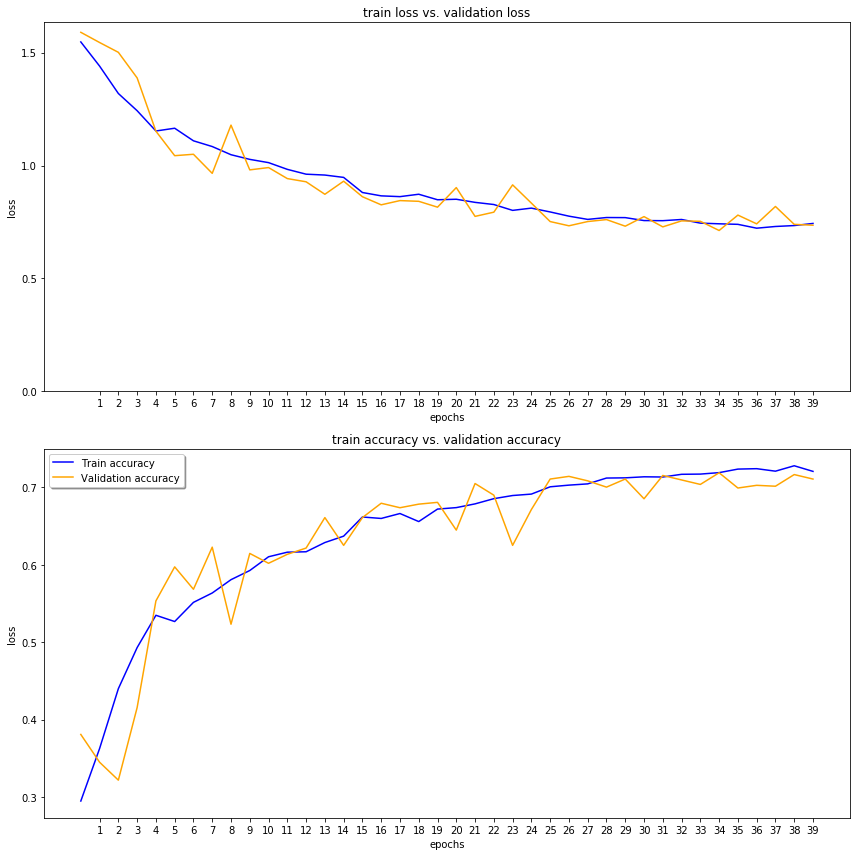

In [11]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))
ax1.plot(hist.history['loss'], color='b', label="Train loss")
ax1.plot(hist.history['val_loss'], color='#ffa500', label="Validation loss")
ax1.set_xticks(np.arange(1, epochs, 1))
ax1.set_yticks(np.arange(0, 2, 0.5))
ax1.set_ylabel('loss')
ax1.set_title('train loss vs. validation loss')
ax1.set_xlabel('epochs')

ax2.plot(hist.history['accuracy'], color='b', label="Train accuracy")
ax2.plot(hist.history['val_accuracy'], color='#ffa500',label="Validation accuracy")
ax2.set_xticks(np.arange(1, epochs, 1))
ax2.set_ylabel('loss')
ax2.set_title('train accuracy vs. validation accuracy')
ax2.set_xlabel('epochs')

legend = plt.legend(loc='best', shadow=True)
plt.tight_layout()
plt.show()